In [4]:
%pip install --no-build-isolation --no-cache-dir --force-reinstall gdal==3.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.9/755.9 kB 12.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for gdal: filename=GDAL-3.4.1-cp312-cp312-linux_x86_64.whl size=1063792 sha256=abef1c77f74d5cebefd5e5bb2b9c5a0e7a1e0a652e0cd91f99a8848e23a70b18
  Stored in directory: /tmp/pip-ephem-wheel-cache-kc7wyxlf/wheels/9f/18/e5/33cb40f2506264cdfc231a7c8eb0ae722ce1e6ba63f870a20c
Successfully built gdal
  Attempting uninstall: gdal
    Found existing installation: GDAL 3.4.1
    Uninstalling GDAL-3.4.1:
      Successfully uninstalled GDAL-3.4.1
Note: you may need to restart the kernel to use updated packages.


In [7]:
import sys
sys.path.append('../')
import os
from utils.imageprocessing import split, createPNG_Dataset,createPNG_Dataset_old, convert_TIFtoPNG, convert_PNGtoSHP, show_image
from utils.datasetvalidation import dropna_SHPs, set_valid_CRS

# Pipeline

In [8]:
folder = '../data/2024-04-21-dataset/standard/original'
out_folder = '../data/2024-04-21-dataset/standard/formatted'
size = (200,200)

os.makedirs(folder, exist_ok=True)
os.makedirs(out_folder, exist_ok=True)

In [ ]:
# 1. data prep.
#   - splitting geo. images
split('../data/all_data/2023-02-23_Bakonyszucs_actual.tif',
      '../data/all_data/Fa_pontok.shp',
      folder,
      size)

#   - convert to .png for the model
# convert_TIFtoPNG(folder,out_folder,size)
#     or
# create dataset
dropna_SHPs(os.path.join(folder,'shps'))
set_valid_CRS(os.path.join(folder,'shps'), desired_crs_epsg=23700)
createPNG_Dataset(folder,out_folder,size, point_size=28, grayscale=False)


# 2. prediction

# ****
# model pred.
#print('predicted')
# ****

# 4. Convert the predictions back
#convert_PNGtoSHP(folder,out_folder,'../results')

splitting tifs:   0%|          | 0/10788 [00:00<?, ?it/s]

splitting shps:   0%|          | 0/10788 [00:00<?, ?it/s]

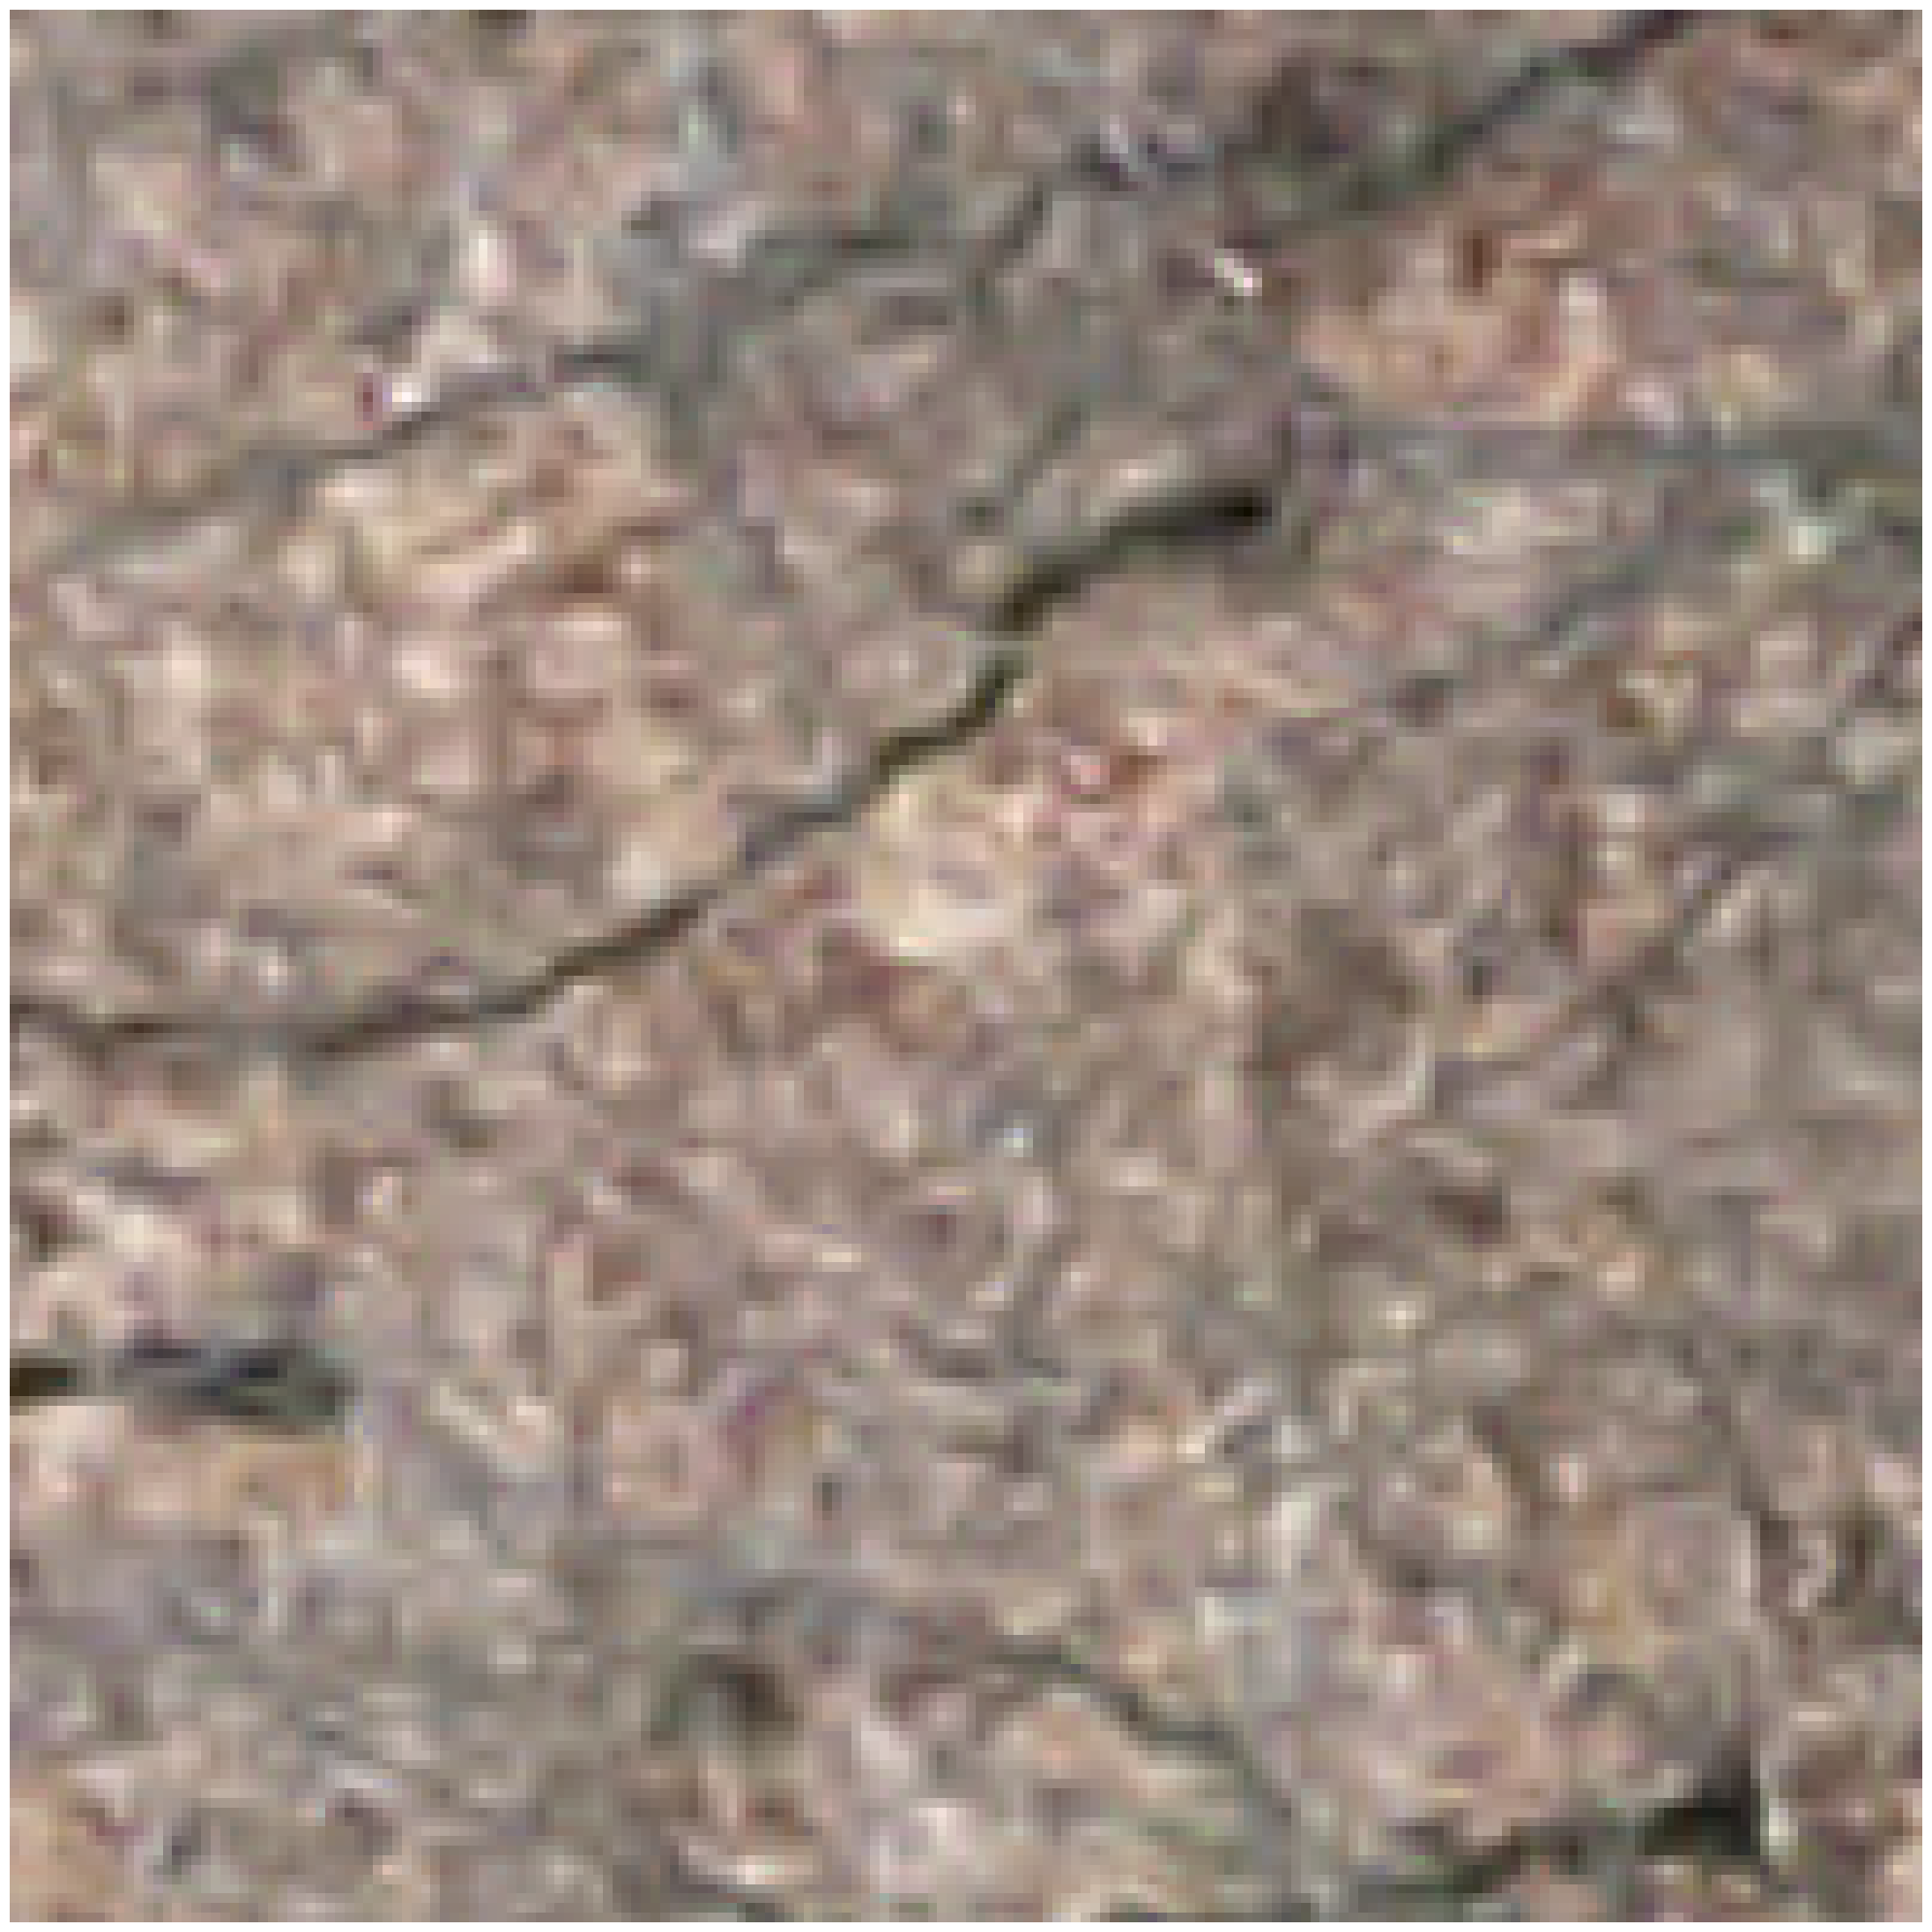

In [7]:
show_image('../data/2024-04-13_dataset/standard/formatted/images/tile_tif_30_15.png',10)

In [10]:
import cv2
import numpy as np

In [15]:
img = cv2.imread('../data/tiles/formatted/tile_tif_2_4.png')
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Calculate the minimum pixel value
min_pixel_value = np.min(gray_image)
print(np.max(gray_image))
norm_gray_image = gray_image / 255
norm_gray_image

255


array([[0.27843137, 0.2627451 , 0.25490196, ..., 0.        , 0.        ,
        0.        ],
       [0.26666667, 0.25490196, 0.24705882, ..., 0.        , 0.        ,
        0.        ],
       [0.25490196, 0.24313725, 0.23529412, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [12]:
from osgeo import gdal
import numpy as np
import cv2

In [10]:
tif_path = '../data/2024-03-16_dataset/standard/original/tile_tif_0_27.tif'
out_path = '../data/2024-03-16_dataset/standard/tile_tif_0_27.png'
tile_size = (500,500)

In [14]:
def scale_pixel_values(input_dataset):
    """
    scaling the pixel values 
    w/ numpy
    """
    
    band = input_dataset.GetRasterBand(1)
    data = band.ReadAsArray()
    
    if np.any(data < 0):
        mask = (data > 200) & (data < 250)
        non_neg_min_val = np.min(data[mask])
        data[data < 0] = non_neg_min_val
        
    min_val = np.min(data)
    max_val = np.max(data)
    
    scale = 65535
    scaled_data = ((data - min_val) / (max_val - min_val) * scale).astype(np.uint16)

    return scaled_data

def extend_image_shape(image_array: np.array, size=(250,250)):
    """
    extends the image shape to the desired shape 
    w/ numpy
    """
    new_image_array = np.zeros(size, dtype=image_array.dtype)
    start_col=0
    start_row=0

    end_row = start_row + image_array.shape[0]
    end_col = start_col + image_array.shape[1]
    new_image_array[start_row:end_row, start_col:end_col] = image_array

    return new_image_array


tif_file = gdal.Open(tif_path)
scaled = scale_pixel_values(tif_file)
if scaled.shape != tile_size:
    scaled = extend_image_shape(scaled,tile_size)
cv2.imwrite(out_path, scaled)

AttributeError: 'Dataset' object has no attribute 'shape'

In [16]:
import numpy as np
from osgeo import gdal
import cv2

def scale_pixel_values(input_dataset):
    """
    Scaling the pixel values
    with numpy
    """
    band = input_dataset.GetRasterBand(1)
    data = band.ReadAsArray()

    if np.any(data < 0):
        mask = (data > 200) & (data < 250)
        non_neg_min_val = np.min(data[mask])
        data[data < 0] = non_neg_min_val

    min_val = np.min(data)
    max_val = np.max(data)

    scale = 65535
    scaled_data = ((data - min_val) / (max_val - min_val) * scale).astype(np.uint16)

    return scaled_data

def extend_image_shape(image_array: np.array, size=(250, 250)):
    """
    Extends the image shape to the desired shape
    with numpy
    """
    new_image_array = np.zeros(size, dtype=image_array.dtype)
    start_col = 0
    start_row = 0

    end_row = start_row + image_array.shape[0]
    end_col = start_col + image_array.shape[1]
    new_image_array[start_row:end_row, start_col:end_col] = image_array

    return new_image_array

def save_color_image(out_path, scaled_data, tif_file):
    """
    Save color image maintaining the original color mapping
    """
    red_band = tif_file.GetRasterBand(3).ReadAsArray()
    green_band = tif_file.GetRasterBand(2).ReadAsArray()
    blue_band = tif_file.GetRasterBand(1).ReadAsArray()

    scaled_color_image = np.stack((red_band, green_band, blue_band), axis=-1)
    scaled_color_image = cv2.normalize(scaled_color_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    cv2.imwrite(out_path, scaled_color_image)

tif_file = gdal.Open(tif_path)
scaled = scale_pixel_values(tif_file)
if scaled.shape != tile_size:
    scaled = extend_image_shape(scaled, tile_size)
save_color_image(out_path, scaled, tif_file)


In [17]:
def scale_pixel_values(input_dataset):
    """
    scaling the pixel values 
    w/ numpy
    """
    
    band = input_dataset.GetRasterBand(1)
    data = band.ReadAsArray()
    
    if np.any(data < 0):
        mask = (data > 200) & (data < 250)
        non_neg_min_val = np.min(data[mask])
        data[data < 0] = non_neg_min_val
        
    min_val = np.min(data)
    max_val = np.max(data)
    
    scale = 65535
    scaled_data = ((data - min_val) / (max_val - min_val) * scale).astype(np.uint16)

    return scaled_data

def extend_image_shape(image_array: np.array, size=(250,250)):
    """
    extends the image shape to the desired shape 
    w/ numpy
    """
    new_image_array = np.zeros(size, dtype=image_array.dtype)
    start_col=0
    start_row=0

    end_row = start_row + image_array.shape[0]
    end_col = start_col + image_array.shape[1]
    new_image_array[start_row:end_row, start_col:end_col] = image_array

    return new_image_array

def save_color_image(out_path, scaled_data, tif_file):
    """
    Save color image maintaining the original color mapping
    """
    red_band = tif_file.GetRasterBand(3).ReadAsArray()
    green_band = tif_file.GetRasterBand(2).ReadAsArray()
    blue_band = tif_file.GetRasterBand(1).ReadAsArray()

    scaled_color_image = np.stack((red_band, green_band, blue_band), axis=-1)
    scaled_color_image = cv2.normalize(scaled_color_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    cv2.imwrite(out_path, scaled_color_image)


tif_file = gdal.Open(tif_path)
scaled = scale_pixel_values(tif_file)
if scaled.shape != tile_size:
    scaled = extend_image_shape(scaled,tile_size)
save_color_image(out_path, scaled,tif_file)